In [1]:
from env import host, user, password
import acquire
import prepare
import wrangle

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Acquire

In [3]:
def get_connection(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    from env import host, user, password
    return f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

In [4]:
def get_zillow():
    '''
    This function reads in the Zillow data from the Codeup db
    with properties_2017, predictions_2017 and propertylandusetype tables joined
    returns: a pandas DataFrame 
    '''
    
    zp_query = '''
    SELECT calculatedfinishedsquarefeet, bedroomcnt, bathroomcnt, taxvaluedollarcnt, taxamount, yearbuilt, fips
    FROM properties_2017
    JOIN predictions_2017 ON properties_2017.parcelid = predictions_2017.parcelid
    JOIN propertylandusetype ON properties_2017.propertylandusetypeid= propertylandusetype.propertylandusetypeid
    WHERE predictions_2017.transactiondate BETWEEN '2017-05-01' AND '2017-08-31' AND properties_2017.propertylandusetypeid IN (31, 46, 47, 260, 261, 262, 263, 264, 265, 268, 273, 274, 275, 276, 279);
    '''
    return pd.read_sql(zp_query, get_connection('zillow'))

In [5]:
df = get_zillow()

# Prepare

In [6]:
df.head()

,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt,taxamount,yearbuilt,fips
0,1316.0,3.0,2.0,205123.0,2627.48,1923.0,6037.0
1,1458.0,3.0,2.0,136104.0,2319.90,1970.0,6037.0
2,1421.0,2.0,1.0,35606.0,543.69,1911.0,6037.0
3,2541.0,4.0,3.0,880456.0,9819.72,2003.0,6059.0
4,1491.0,3.0,2.0,107110.0,1399.27,1955.0,6037.0


In [7]:
#calculate tax rate
df['tax_rate'] =df['taxamount']/  df['taxvaluedollarcnt']

In [8]:
#28,418 entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28418 entries, 0 to 28417
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  28345 non-null  float64
 1   bedroomcnt                    28418 non-null  float64
 2   bathroomcnt                   28418 non-null  float64
 3   taxvaluedollarcnt             28417 non-null  float64
 4   taxamount                     28417 non-null  float64
 5   yearbuilt                     28322 non-null  float64
 6   fips                          28418 non-null  float64
 7   tax_rate                      28416 non-null  float64
dtypes: float64(8)
memory usage: 1.7 MB


In [9]:
#change datatype from float to integer
#df['calculatedfinishedsquarefeet'] = df['calculatedfinishedsquarefeet'].astype(int)

In [10]:
#check for duplicates
df.drop_duplicates(inplace=True)

In [11]:
#28,385 entries (removed 33 duplicates)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28385 entries, 0 to 28417
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  28314 non-null  float64
 1   bedroomcnt                    28385 non-null  float64
 2   bathroomcnt                   28385 non-null  float64
 3   taxvaluedollarcnt             28384 non-null  float64
 4   taxamount                     28384 non-null  float64
 5   yearbuilt                     28291 non-null  float64
 6   fips                          28385 non-null  float64
 7   tax_rate                      28383 non-null  float64
dtypes: float64(8)
memory usage: 1.9 MB


In [12]:
# replace nan values
df.replace(r'^\s*$', np.nan, regex=True)

,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt,taxamount,yearbuilt,fips,tax_rate
0,1316.0,3.0,2.0,205123.0,2627.48,1923.0,6037.0,0.012809
1,1458.0,3.0,2.0,136104.0,2319.90,1970.0,6037.0,0.017045
2,1421.0,2.0,1.0,35606.0,543.69,1911.0,6037.0,0.015270
3,2541.0,4.0,3.0,880456.0,9819.72,2003.0,6059.0,0.011153
4,1491.0,3.0,2.0,107110.0,1399.27,1955.0,6037.0,0.013064
...,...,...,...,...,...,...,...,...
28413,2634.0,6.0,2.0,878190.0,12766.88,1921.0,6037.0,0.014538
28414,1187.0,4.0,1.5,465999.0,5552.68,1959.0,6059.0,0.011916
28415,3015.0,5.0,3.0,852813.0,11662.88,2002.0,6059.0,0.013676
28416,2992.0,5.0,3.0,1120000.0,13663.03,1977.0,6037.0,0.012199


In [13]:
#drop na values (100 na values)
df.dropna()

,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt,taxamount,yearbuilt,fips,tax_rate
0,1316.0,3.0,2.0,205123.0,2627.48,1923.0,6037.0,0.012809
1,1458.0,3.0,2.0,136104.0,2319.90,1970.0,6037.0,0.017045
2,1421.0,2.0,1.0,35606.0,543.69,1911.0,6037.0,0.015270
3,2541.0,4.0,3.0,880456.0,9819.72,2003.0,6059.0,0.011153
4,1491.0,3.0,2.0,107110.0,1399.27,1955.0,6037.0,0.013064
...,...,...,...,...,...,...,...,...
28413,2634.0,6.0,2.0,878190.0,12766.88,1921.0,6037.0,0.014538
28414,1187.0,4.0,1.5,465999.0,5552.68,1959.0,6059.0,0.011916
28415,3015.0,5.0,3.0,852813.0,11662.88,2002.0,6059.0,0.013676
28416,2992.0,5.0,3.0,1120000.0,13663.03,1977.0,6037.0,0.012199


In [14]:
df.nunique()

calculatedfinishedsquarefeet     4057
bedroomcnt                         13
bathroomcnt                        20
taxvaluedollarcnt               22933
taxamount                       27938
yearbuilt                         131
fips                                3
tax_rate                        28352
dtype: int64

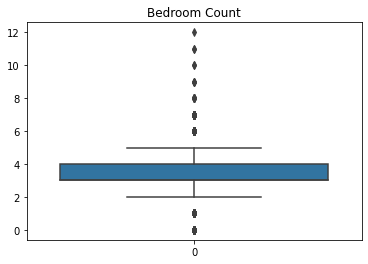

In [15]:
sns.boxplot(data=df.bedroomcnt)
plt.title('Bedroom Count')
plt.show()

#outliers can be seen here

In [16]:
df.bedroomcnt.describe()

count    28385.000000
mean         3.297939
std          0.950496
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         12.000000
Name: bedroomcnt, dtype: float64

In [17]:
#finding IQR of bedrooms to find outliers
Q1 = df['bedroomcnt'].quantile(0.25)
Q3 = df['bedroomcnt'].quantile(0.75)
IQR = Q3 - Q1
IQR, Q3, Q1

(1.0, 4.0, 3.0)

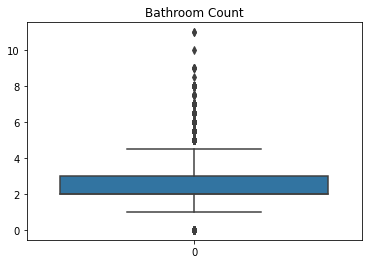

In [18]:
sns.boxplot(data=df.bathroomcnt)
plt.title('Bathroom Count')
plt.show()

In [19]:
df.bathroomcnt.describe()

count    28385.000000
mean         2.311027
std          1.016924
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: bathroomcnt, dtype: float64

In [20]:
#finding IQR of bathrooms to find outliers
Q1 = df['bathroomcnt'].quantile(0.25)
Q3 = df['bathroomcnt'].quantile(0.75)
IQR = Q3 - Q1
IQR, Q3, Q1

(1.0, 3.0, 2.0)

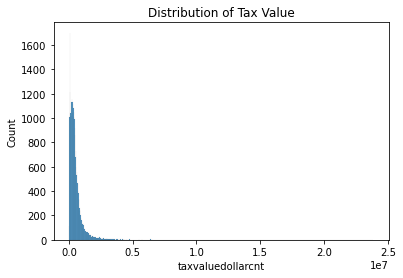

In [21]:
#taxvalue distribution
sns.histplot(data=df.taxvaluedollarcnt)
plt.title('Distribution of Tax Value')
plt.show()

In [22]:
df.taxvaluedollarcnt.describe()

count    2.838400e+04
mean     5.328620e+05
std      7.052775e+05
min      1.000000e+03
25%      1.983520e+05
50%      3.807325e+05
75%      6.298532e+05
max      2.385837e+07
Name: taxvaluedollarcnt, dtype: float64

In [23]:
#finding IQR of Tax Value to find outliers
Q1 = df['taxvaluedollarcnt'].quantile(0.25)
Q3 = df['taxvaluedollarcnt'].quantile(0.75)
IQR = Q3 - Q1
IQR, Q3, Q1

(431501.25, 629853.25, 198352.0)

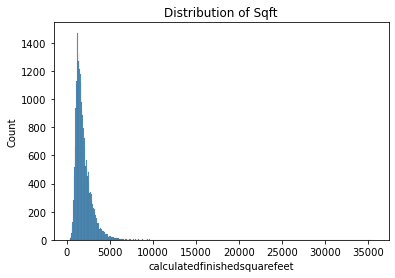

In [24]:
#sqft distribution
sns.histplot(data=df.calculatedfinishedsquarefeet)
plt.title('Distribution of Sqft')
plt.show()

In [25]:
df.calculatedfinishedsquarefeet.describe()

count    28314.000000
mean      1931.298156
std       1012.060652
min        240.000000
25%       1277.000000
50%       1669.000000
75%       2319.000000
max      35640.000000
Name: calculatedfinishedsquarefeet, dtype: float64

In [26]:
#finding IQR of Tax Value to find outliers
Q1 = df['calculatedfinishedsquarefeet'].quantile(0.25)
Q3 = df['calculatedfinishedsquarefeet'].quantile(0.75)
IQR = Q3 - Q1
IQR, Q3, Q1

(1042.0, 2319.0, 1277.0)

In [27]:
#split 


In [28]:
#take a look at X_train


In [29]:
#scale data


In [30]:
#now take a look at X_train after being scaled (minmaxscaler)


# Explore

In [31]:
y_train.describe()

NameError: name 'y_train' is not defined

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
y_train.head()